In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import math
import cv2
import os
import tensorflow as tf
from sklearn.utils import class_weight
import random
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report



C:\Users\Anushka Pawar\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading the MURA dataset 
mura_df = pd.read_csv('Mura_final.csv')

In [3]:
print("Sample of the MURA dataset:")
print(mura_df.head())

Sample of the MURA dataset:
                                               Names  Labels
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...       1
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...       1
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...       1
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...       1
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...       1


In [4]:
# Statistic summary
print("Summary statistics of the MURA dataset:")
print(mura_df.describe())

Summary statistics of the MURA dataset:
             Labels
count  40005.000000
mean       0.410024
std        0.491844
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [5]:
mura_df['Body_part']=''
for i in range (len(mura_df)):
    if 'SHOULDER' in mura_df.iloc[i,0]:
        mura_df.iloc[i,2]= 'SHOULDER'
    if 'ELBOW' in mura_df.iloc[i,0]:
        mura_df.iloc[i,2]= 'ELBOW'
    if 'FINGER' in mura_df.iloc[i,0]:
        mura_df.iloc[i,2]= 'FINGER'
    if 'FOREARM' in mura_df.iloc[i,0]:
        mura_df.iloc[i,2]= 'FOREARM'
    if 'HAND' in mura_df.iloc[i,0]:
        mura_df.iloc[i,2]= 'HAND'
    if 'WRIST' in mura_df.iloc[i,0]:
        mura_df.iloc[i,2]= 'WRIST'
    if 'HUMERUS' in mura_df.iloc[i,0]:
        mura_df.iloc[i,2]= 'HUMERUS'


Exploratory Data Analysis

In [6]:
# Checking for missing values
print("Missing values in the MURA dataset:")
print(mura_df.isnull().sum())

Missing values in the MURA dataset:
Names        0
Labels       0
Body_part    0
dtype: int64


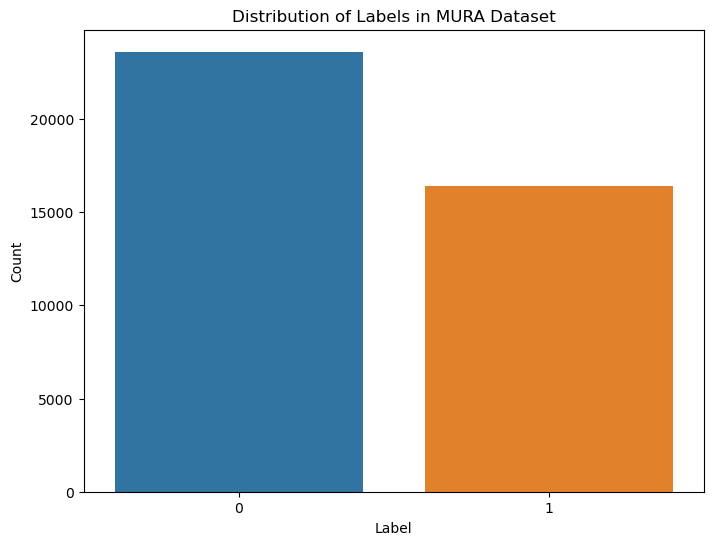

In [7]:
# Visualization: Distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(x='Labels', data=mura_df)
plt.title('Distribution of Labels in MURA Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

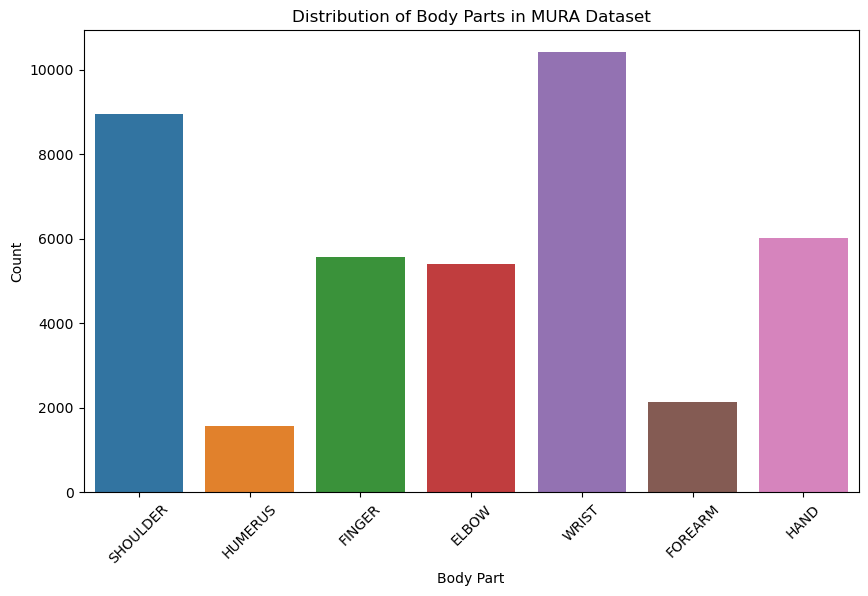

In [8]:
# Visualization: Distribution of body parts
plt.figure(figsize=(10, 6))
sns.countplot(x='Body_part', data=mura_df)
plt.title('Distribution of Body Parts in MURA Dataset')
plt.xlabel('Body Part')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

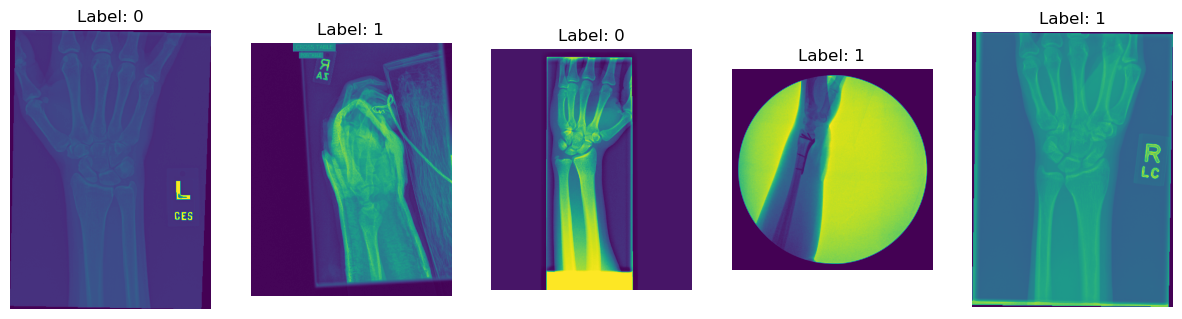

In [9]:
# Visualization: Sample images
sample_images = mura_df.sample(n=5) 
plt.figure(figsize=(15, 5))
for i, (_, row) in enumerate(sample_images.iterrows()):
    image_path = row['Names']  
    label = row['Labels'] 
    image = Image.open(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

1. found twisted images
2. black and white inages.
3. variation in the image sizes.

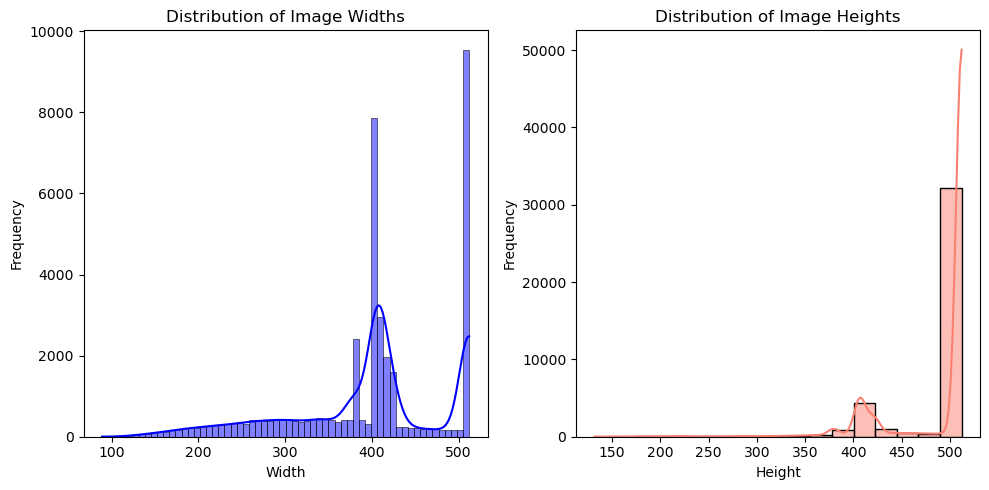

In [10]:
# Function to get the size of images
def get_image_size(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        height, width, _ = image.shape
        return width, height
    else:
        return None

#size of images
image_sizes = []
for image_path in mura_df['Names']:  
    size = get_image_size(image_path)
    if size is not None:
        image_sizes.append(size)

image_sizes = np.array(image_sizes)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(image_sizes[:, 0], kde=True, color='blue')
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(image_sizes[:, 1], kde=True, color='salmon')
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [11]:
# Loop through each row in the DataFrame
for index, row in mura_df.iterrows():
    image_path = row['Names']  
    
    image = cv2.imread(image_path)
    
    # Converting the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Saving the grayscale image (overwrite the original file)
    cv2.imwrite(image_path, gray_image)

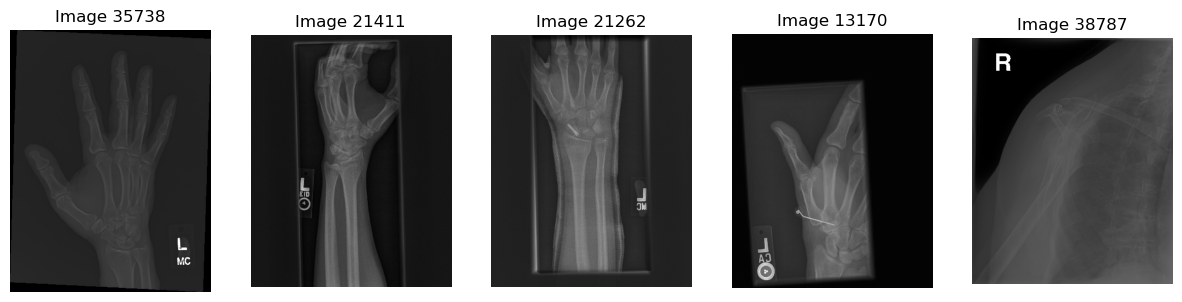

In [12]:
sample_indices = random.sample(range(len(mura_df)), 5)
# Plot sample images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices, 1):
    img_path = mura_df.iloc[idx]['Names']  # Assuming 'Image_Path' is the column name containing image paths
    img = cv2.imread(img_path)
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title("Image {}".format(idx))
    plt.axis('off')
plt.show()

In [13]:
#Shuffle the rows of the dataset
shuffled_df = mura_df.sample(frac=1, random_state=42).reset_index(drop=True)  

# Save the shuffled dataset back to the original file
shuffled_df.to_csv('Mura_final2.csv', index=False)

# Confirming the shuffling
print("Original dataset:")
print(mura_df.head())

print("\nShuffled dataset:")
print(shuffled_df.head())

Original dataset:
                                               Names  Labels Body_part
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...       1  SHOULDER
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...       1  SHOULDER
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...       1  SHOULDER
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...       1  SHOULDER
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...       1  SHOULDER

Shuffled dataset:
                                               Names  Labels Body_part
0  MURA-v1.1/train/XR_ELBOW/patient05190/study1_p...       1     ELBOW
1  MURA-v1.1/train/XR_SHOULDER/patient00531/study...       1  SHOULDER
2  MURA-v1.1/train/XR_WRIST/patient06778/study2_p...       1     WRIST
3  MURA-v1.1/train/XR_ELBOW/patient05231/study1_p...       1     ELBOW
4  MURA-v1.1/train/XR_SHOULDER/patient01825/study...       0  SHOULDER


In [14]:
mura_df2 = pd.read_csv('Mura_final2.csv')
print(mura_df2.head())

                                               Names  Labels Body_part
0  MURA-v1.1/train/XR_ELBOW/patient05190/study1_p...       1     ELBOW
1  MURA-v1.1/train/XR_SHOULDER/patient00531/study...       1  SHOULDER
2  MURA-v1.1/train/XR_WRIST/patient06778/study2_p...       1     WRIST
3  MURA-v1.1/train/XR_ELBOW/patient05231/study1_p...       1     ELBOW
4  MURA-v1.1/train/XR_SHOULDER/patient01825/study...       0  SHOULDER


In [15]:
image_paths = mura_df2["Names"]
labels = mura_df2["Body_part"]

In [30]:
# Split data into training and validation sets
train_df, val_df = train_test_split(mura_df2, test_size=0.2, random_state=42)


# Defining image size
img_height, img_width = 400, 500

In [31]:
# Encode labels using OneHotEncoder
encoder = OneHotEncoder(sparse=False)
train_labels_encoded = encoder.fit_transform(train_labels.values.reshape(-1, 1))
validation_labels_encoded = encoder.transform(validation_labels.values.reshape(-1, 1))



In [32]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
# Define the data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Names',
    y_col='Body_part',  # No need to specify y_col
    batch_size=30,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

# Define the validation data generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Names',
    y_col='Body_part',  # No need to specify y_col
    batch_size=30,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 32004 validated image filenames belonging to 7 classes.
Found 8001 validated image filenames belonging to 7 classes.


In [34]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [36]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [37]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

Epoch 1/20
1067/1067 [==============================] - 1417s 1s/step - loss: 1.2846 - accuracy: 0.5437 - val_loss: 0.9824 - val_accuracy: 0.6588
Epoch 2/20
1067/1067 [==============================] - 1282s 1s/step - loss: 1.0175 - accuracy: 0.6395 - val_loss: 0.8261 - val_accuracy: 0.7222
Epoch 3/20
1067/1067 [==============================] - 1236s 1s/step - loss: 0.9262 - accuracy: 0.6692 - val_loss: 0.7361 - val_accuracy: 0.7455
Epoch 4/20
1067/1067 [==============================] - 1228s 1s/step - loss: 0.8694 - accuracy: 0.6944 - val_loss: 0.7190 - val_accuracy: 0.7555
Epoch 5/20
1067/1067 [==============================] - 1229s 1s/step - loss: 0.8391 - accuracy: 0.7096 - val_loss: 0.7011 - val_accuracy: 0.7629
Epoch 6/20
1067/1067 [==============================] - 1545s 1s/step - loss: 0.8020 - accuracy: 0.7206 - val_loss: 0.6744 - val_accuracy: 0.7723
Epoch 7/20
1067/1067 [==============================] - 1681s 2s/step - loss: 0.7898 - accuracy: 0.7272 - val_loss: 0.6611 -

In [38]:
# Evaluate the model on the validation set
validation_results = model.evaluate(validation_generator)

# Predict labels for the validation set
y_pred = model.predict(validation_generator)
y_true = validation_generator.labels

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))

# Calculate precision, recall, and F1-score
class_report = classification_report(y_true, y_pred.argmax(axis=1), target_names=validation_generator.class_indices.keys())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

267/267 [==============================] - 106s 397ms/step
Confusion Matrix:
[[ 902   20   32    9   10   31   82]
 [  23  983    2   64    1   19   32]
 [ 121   39   99    8   16   29   99]
 [  27   61    3 1050    2   13   39]
 [  58    6   11    1  147   76   11]
 [  35   12    2    5    9 1710   26]
 [  22   52   18   75    2   17 1890]]

Classification Report:
              precision    recall  f1-score   support

       ELBOW       0.76      0.83      0.79      1086
      FINGER       0.84      0.87      0.86      1124
     FOREARM       0.59      0.24      0.34       411
        HAND       0.87      0.88      0.87      1195
     HUMERUS       0.79      0.47      0.59       310
    SHOULDER       0.90      0.95      0.93      1799
       WRIST       0.87      0.91      0.89      2076

    accuracy                           0.85      8001
   macro avg       0.80      0.74      0.75      8001
weighted avg       0.84      0.85      0.84      8001

